In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, .01, .01)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=16,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=17,
            classes=5,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=17,
            classes=1,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=17,
            classes=1,
        )

    def forward(self, x):
        cloud_mask_pred = self.cloud_mask_net(x)  # [B,1,H,W]
        x1 = torch.cat([x, cloud_mask_pred], dim=1)  # [B,17,H,W]

        cloud_phase_pred = self.cloud_phase_net(x1)  # [B,5,H,W]
        cod_pred = self.cod_net(x1)                # [B,1,H,W]
        cps_pred = self.cps_net(x1)                # [B,1,H,W]

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred



In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV1().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f}")

100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 1 | Train Loss: 5.1840 | Val Loss: 4.7541


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 2 | Train Loss: 4.4298 | Val Loss: 4.2409


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 3 | Train Loss: 4.0476 | Val Loss: 3.9163


100%|██████████| 94/94 [00:37<00:00,  2.53it/s]


Epoch: 4 | Train Loss: 3.8145 | Val Loss: 3.8483


100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


Epoch: 5 | Train Loss: 3.6401 | Val Loss: 3.6307


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 6 | Train Loss: 3.4917 | Val Loss: 3.7413


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 7 | Train Loss: 3.3637 | Val Loss: 3.4807


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 8 | Train Loss: 3.2553 | Val Loss: 3.3524


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 9 | Train Loss: 3.1617 | Val Loss: 3.3496


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 10 | Train Loss: 3.0761 | Val Loss: 3.3405


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 11 | Train Loss: 2.9987 | Val Loss: 3.3476


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 12 | Train Loss: 2.9102 | Val Loss: 3.2142


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 13 | Train Loss: 2.8286 | Val Loss: 2.9809


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 14 | Train Loss: 2.7498 | Val Loss: 2.8673


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 15 | Train Loss: 2.6743 | Val Loss: 3.0311


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 16 | Train Loss: 2.5808 | Val Loss: 2.8621


100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Epoch: 17 | Train Loss: 2.5073 | Val Loss: 3.0764


100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Epoch: 18 | Train Loss: 2.4395 | Val Loss: 2.6801


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 19 | Train Loss: 2.3709 | Val Loss: 2.6230


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 20 | Train Loss: 2.3023 | Val Loss: 3.0087


100%|██████████| 94/94 [00:24<00:00,  3.92it/s]


Epoch: 21 | Train Loss: 2.2283 | Val Loss: 2.5375


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 22 | Train Loss: 2.1716 | Val Loss: 2.5218


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 23 | Train Loss: 2.1172 | Val Loss: 2.2790


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 24 | Train Loss: 2.0565 | Val Loss: 2.2676


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 25 | Train Loss: 2.0072 | Val Loss: 2.4224


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 26 | Train Loss: 1.9532 | Val Loss: 2.2361


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 27 | Train Loss: 1.9208 | Val Loss: 2.3745


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 28 | Train Loss: 1.8631 | Val Loss: 2.3079


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 29 | Train Loss: 1.8193 | Val Loss: 2.1767


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 30 | Train Loss: 1.7651 | Val Loss: 2.5480


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 31 | Train Loss: 1.7299 | Val Loss: 2.3970


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 32 | Train Loss: 1.6913 | Val Loss: 2.1510


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 33 | Train Loss: 1.6488 | Val Loss: 1.9735


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 34 | Train Loss: 1.6119 | Val Loss: 1.9763


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 35 | Train Loss: 1.5743 | Val Loss: 2.0009


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 36 | Train Loss: 1.5406 | Val Loss: 2.1339


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 37 | Train Loss: 1.5065 | Val Loss: 2.5297


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 38 | Train Loss: 1.4883 | Val Loss: 1.9305


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 39 | Train Loss: 1.4541 | Val Loss: 2.1111


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 40 | Train Loss: 1.4185 | Val Loss: 1.8477


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 41 | Train Loss: 1.3933 | Val Loss: 1.7138


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 42 | Train Loss: 1.3623 | Val Loss: 1.8606


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 43 | Train Loss: 1.3389 | Val Loss: 1.8199


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 44 | Train Loss: 1.3141 | Val Loss: 1.8904


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 45 | Train Loss: 1.2850 | Val Loss: 1.7882


100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Epoch: 46 | Train Loss: 1.2617 | Val Loss: 1.7128


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 47 | Train Loss: 1.2482 | Val Loss: 3.3441


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 48 | Train Loss: 1.2222 | Val Loss: 2.2913


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 49 | Train Loss: 1.1987 | Val Loss: 2.2769


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 50 | Train Loss: 1.1799 | Val Loss: 1.6583


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 51 | Train Loss: 1.1629 | Val Loss: 3.0366


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 52 | Train Loss: 1.1513 | Val Loss: 1.7396


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 53 | Train Loss: 1.1239 | Val Loss: 1.6971


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 54 | Train Loss: 1.1034 | Val Loss: 1.7536


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 55 | Train Loss: 1.0882 | Val Loss: 1.4787


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 56 | Train Loss: 1.0630 | Val Loss: 1.6578


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 57 | Train Loss: 1.0476 | Val Loss: 1.5131


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 58 | Train Loss: 1.0502 | Val Loss: 1.6628


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 59 | Train Loss: 1.0272 | Val Loss: 1.6646


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 60 | Train Loss: 1.0187 | Val Loss: 1.6032


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 61 | Train Loss: 0.9966 | Val Loss: 1.7100


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 62 | Train Loss: 0.9766 | Val Loss: 3.4389


100%|██████████| 94/94 [00:25<00:00,  3.76it/s]


Epoch: 63 | Train Loss: 0.9616 | Val Loss: 1.4537


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 64 | Train Loss: 0.9554 | Val Loss: 1.4643


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 65 | Train Loss: 0.9416 | Val Loss: 2.6685


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 66 | Train Loss: 0.9321 | Val Loss: 1.5583


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 67 | Train Loss: 0.9248 | Val Loss: 1.5071


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 68 | Train Loss: 0.9115 | Val Loss: 1.5421


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 69 | Train Loss: 0.9016 | Val Loss: 1.5348


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 70 | Train Loss: 0.8866 | Val Loss: 2.4118


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 71 | Train Loss: 0.8807 | Val Loss: 1.5082


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 72 | Train Loss: 0.8726 | Val Loss: 1.3374


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 73 | Train Loss: 0.8572 | Val Loss: 1.5496


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 74 | Train Loss: 0.8527 | Val Loss: 2.1708


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 75 | Train Loss: 0.8517 | Val Loss: 1.4986


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 76 | Train Loss: 0.8560 | Val Loss: 1.4979


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 77 | Train Loss: 0.8355 | Val Loss: 1.3402


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 78 | Train Loss: 0.8273 | Val Loss: 1.8164


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 79 | Train Loss: 0.8174 | Val Loss: 1.7589


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 80 | Train Loss: 0.8110 | Val Loss: 2.1927


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 81 | Train Loss: 0.8034 | Val Loss: 1.4703


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 82 | Train Loss: 0.8019 | Val Loss: 2.1687


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 83 | Train Loss: 0.8147 | Val Loss: 1.3696


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 84 | Train Loss: 0.7981 | Val Loss: 1.5424


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 85 | Train Loss: 0.7920 | Val Loss: 1.6476


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 86 | Train Loss: 0.7824 | Val Loss: 1.5942


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 87 | Train Loss: 0.7758 | Val Loss: 1.4370


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 88 | Train Loss: 0.7696 | Val Loss: 1.5180


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 89 | Train Loss: 0.7692 | Val Loss: 1.3061


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 90 | Train Loss: 0.7608 | Val Loss: 1.3318


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 91 | Train Loss: 0.7601 | Val Loss: 1.3883


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 92 | Train Loss: 0.7559 | Val Loss: 1.5592


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 93 | Train Loss: 0.7529 | Val Loss: 1.2981


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 94 | Train Loss: 0.7448 | Val Loss: 1.3022


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 95 | Train Loss: 0.7504 | Val Loss: 1.3670


100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Epoch: 96 | Train Loss: 0.7444 | Val Loss: 2.2767


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 97 | Train Loss: 0.7466 | Val Loss: 1.4965


100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Epoch: 98 | Train Loss: 0.7399 | Val Loss: 2.2153


100%|██████████| 94/94 [00:23<00:00,  3.92it/s]


Epoch: 99 | Train Loss: 0.7354 | Val Loss: 1.5821


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 100 | Train Loss: 0.7330 | Val Loss: 1.3786


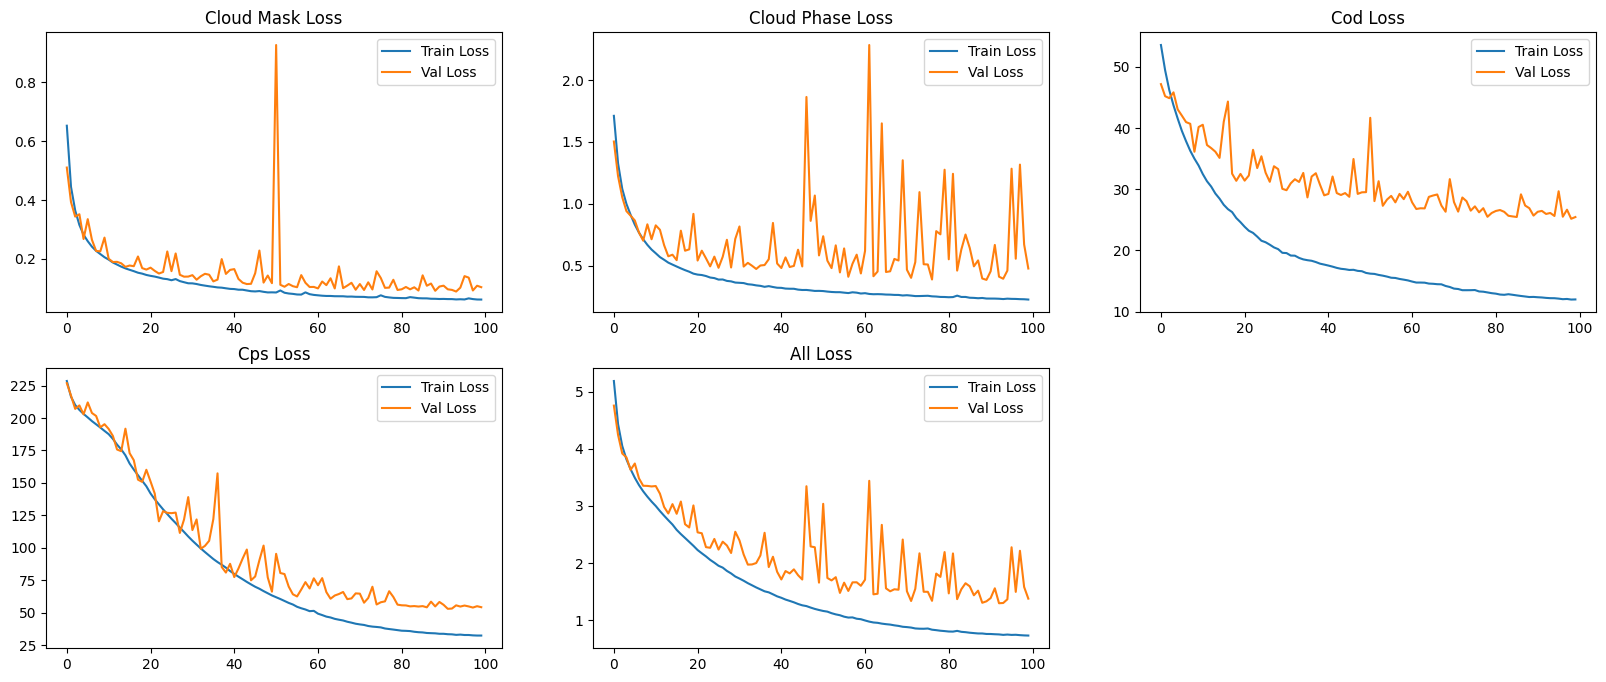

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV1_loss.png")  

plt.show()

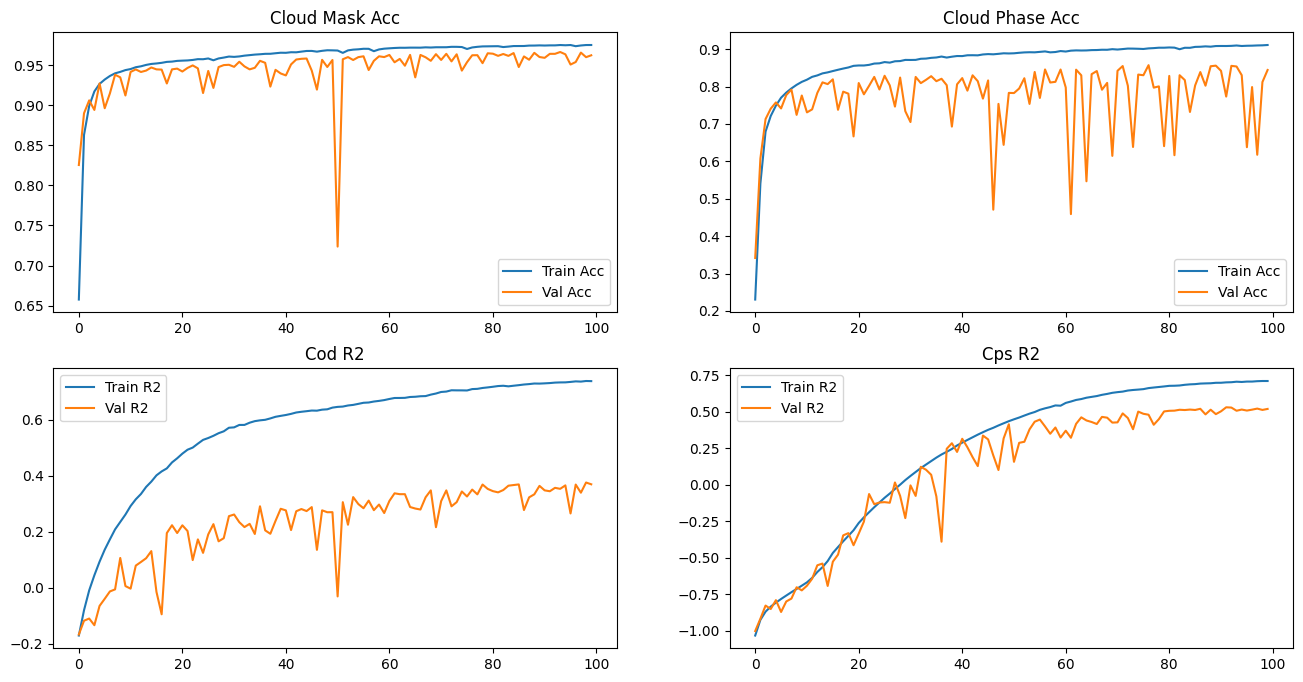

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()


plt.savefig("./graphs/MultiTaskV1_acc.png")  

plt.show()


In [15]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.895     0.938     0.916   5393113
           1      0.982     0.969     0.976  19182887

    accuracy                          0.962  24576000
   macro avg      0.939     0.954     0.946  24576000
weighted avg      0.963     0.962     0.963  24576000

CONFUSION MATRIX:
 [[ 5060899   332214]
 [  594627 18588260]]

IOU: [0.84521021 0.95250647]
Unweighted IoU: 0.8988583423256754
Weighted IoU: 0.9289607015680267


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  7.77it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.922     0.826     0.871   4087755
           1      0.856     0.952     0.901  11278156
           2      0.769     0.876     0.819   3601274
           3      0.447     0.291     0.353   1085137
           4      0.946     0.744     0.833   4523678

    accuracy                          0.852  24576000
   macro avg      0.788     0.738     0.756  24576000
weighted avg      0.853     0.852     0.848  24576000

CONFUSION MATRIX:
 [[ 3374774   692669    10391      195     9726]
 [  245639 10736233   217545     7798    70941]
 [    1830   347008  3156302    77834    18300]
 [     590   133635   543046   315885    91981]
 [   37985   635732   177268   305027  3367666]]

IOU: [0.77158873 0.82036135 0.69376533 0.21401553 0.71430183]
Unweighted IoU: 0.6428065529158016
Weighted IoU: 0.7474029785453347


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  8.26it/s]


r2: 0.3751239776611328
MSE: 29.956323623657227


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


r2: 0.5215030312538147
MSE: 53.02175521850586
